<a href="https://colab.research.google.com/github/dhcryan/ddareung/blob/master/seoul_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import module

- 글꼴 설정 및 모듈 임포트

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list]

In [ ]:
# !sudo apt-get install fonts-nanum*
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install pyproj
# !pip install geopandas

In [28]:
from pyproj import Transformer
import pyproj
from shapely.geometry import Point as point
import geopandas as gpd
import folium
from collections import namedtuple

In [8]:
plt.rcParams["font.family"] = 'NanumGothic'

In [11]:
print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumGothic.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/truetype/nanum/NanumBrush.ttf', '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/nanum/Nan

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  #font 경로 설정
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [ ]:
# mpl.rcParams['axes.unicode_minus'] = False

In [10]:
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())

버전:  3.2.2
설치 위치:  /usr/local/lib/python3.8/dist-packages/matplotlib/__init__.py
설정 위치:  /root/.config/matplotlib
캐시 위치:  /root/.cache/matplotlib


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from geopy.distance import geodesic
from plotnine import *
from scipy import stats

# 2022년도 따릉이 데이터(1월 ~6월) 바탕으로 EDA

## 2022년도 데이터 만들기

In [5]:
# df_2022=pd.read_csv('/home/dhc4003/ddareung/data/seoul_bike_2022.csv',low_memory=False)
df_2022=pd.read_csv('/content/drive/MyDrive/ddareung/seoul_bike_2022.csv',low_memory=False)


In [6]:
### 보니까 대여소가 102번호 이상인거부터 5855 이하까지 유효
df_2022=df_2022[(df_2022.loc[:,'대여대여소']>=102) & (df_2022.loc[:,'대여대여소']<=5855) & (df_2022.loc[:,'반납대여소']>=102) & (df_2022.loc[:,'반납대여소']<=5855)]
df_2022["대여연월"] = df_2022["대여일시"].apply(lambda x : x[:7])
df_2022["대여일시"]=pd.to_datetime(df_2022["대여일시"])

df_2022["대여연도"] = df_2022["대여일시"].dt.year
df_2022["대여월"] = df_2022["대여일시"].dt.month
df_2022["대여일"] = df_2022["대여일시"].dt.day
df_2022["대여시간"] = df_2022["대여일시"].dt.hour
df_2022["대여요일"] = df_2022["대여일시"].dt.dayofweek
df_2022["대여일자"] = df_2022["대여일시"].dt.date

df_2022["반납연월"] = df_2022["반납일시"].apply(lambda x : x[:7])
df_2022["반납일시"]=pd.to_datetime(df_2022["반납일시"])

df_2022["반납일시"]=pd.to_datetime(df_2022["반납일시"])
df_2022["반납연도"] = df_2022["반납일시"].dt.year
df_2022["반납월"] = df_2022["반납일시"].dt.month
df_2022["반납일"] = df_2022["반납일시"].dt.day
df_2022["반납시간"] = df_2022["반납일시"].dt.hour
df_2022["반납요일"] = df_2022["반납일시"].dt.dayofweek
df_2022["반납일자"] = df_2022["반납일시"].dt.date

In [7]:
df_rent_group = df_2022.groupby(["대여일자", "대여연월", "대여연도", "대여월", "대여일", "대여요일"])["대여일시"].count()
df_rent = pd.DataFrame(df_rent_group).reset_index()
df_rent.columns = ["대여일자", "대여연월", "대여연도", 
                   "대여월", "대여일", "대여요일", "대여수"]
df_rent.head()

대여일자     대여연월  대여연도  대여월  대여일  대여요일    대여수
0  2022-01-01  2022-01  2022    1    1     5  29087
1  2022-01-02  2022-01  2022    1    2     6  28820
2  2022-01-03  2022-01  2022    1    3     0  53362
3  2022-01-04  2022-01  2022    1    4     1  56124
4  2022-01-05  2022-01  2022    1    5     2  57190

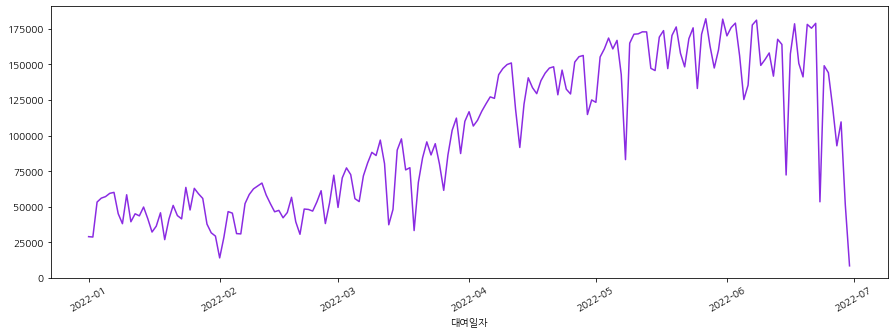

In [8]:
# 일자별 대여량 확인하기
df_rent.groupby('대여일자')['대여수'].mean().plot(rot=30, figsize=(15, 5) ,color='blueviolet')

<AxesSubplot:xlabel='대여연월', ylabel='대여수'>

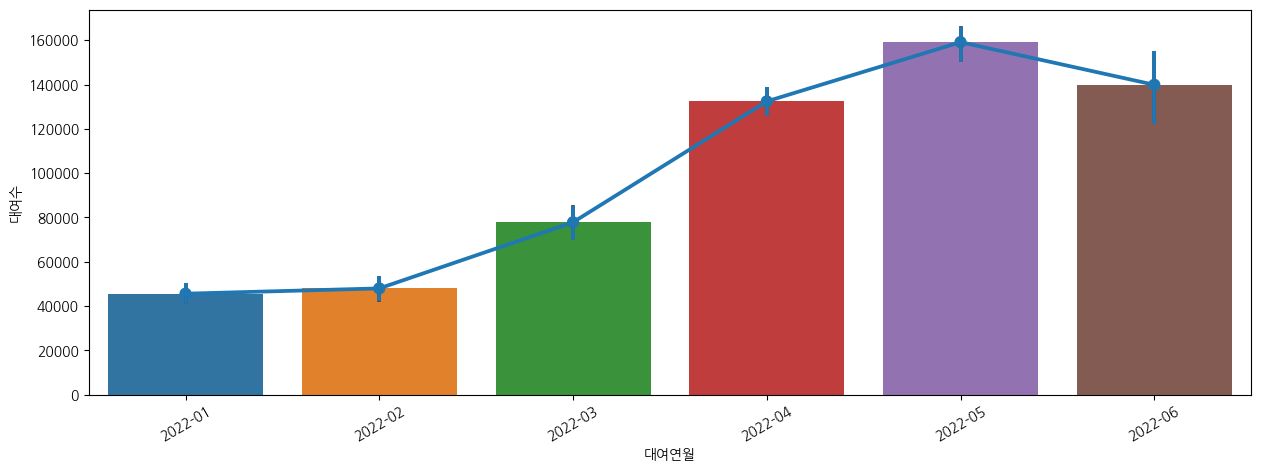

In [ ]:
# 월별 대여량 확인하기
plt.figure(figsize=(15, 5))
plt.xticks(rotation=30)
sns.barplot(data=df_rent, x="대여연월", y="대여수")
sns.pointplot(data=df_rent, x="대여연월", y="대여수")

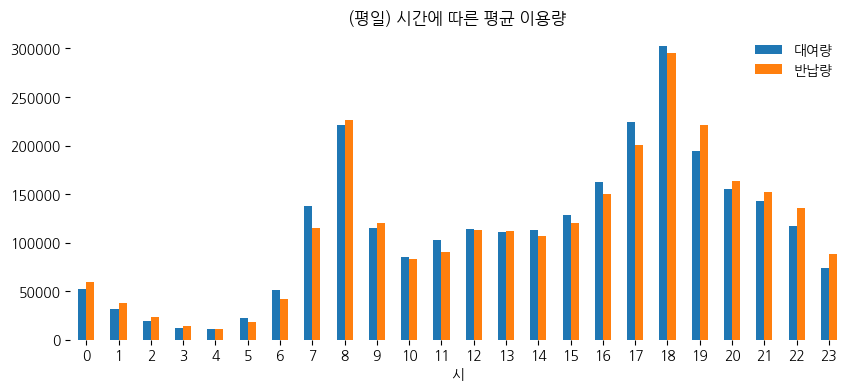

In [ ]:
# 평일의 시간에 따른 사용량 살펴보기
ax = pd.DataFrame(
    data={
        "대여량": df_2022[df_2022['대여요일'] < 5].groupby('대여시간').size() // 5,
        "반납량": df_2022[df_2022['대여요일'] < 5].groupby('반납시간').size() // 5
    }
).plot.bar(
    rot=0,
    xlabel="시",
    title="(평일) 시간에 따른 평균 이용량",
    figsize=(10, 4)
)
ax.set_frame_on(False)
ax.legend(frameon=False)

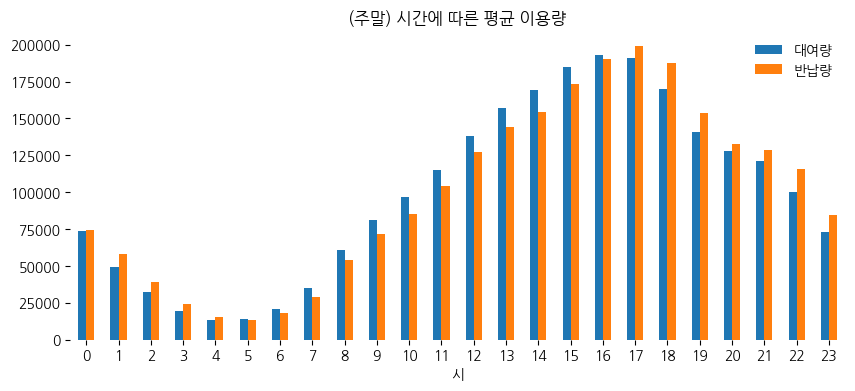

In [ ]:
# 주말의 시간에 따른 사용량 살펴보기
ax = pd.DataFrame(
    data={
        "대여량": df_2022[df_2022['대여요일'] >= 5].groupby('대여시간').size() // 2,
        "반납량": df_2022[df_2022['대여요일'] >= 5].groupby('반납시간').size() // 2
    }
).plot.bar(
    rot=0,
    xlabel="시",
    title="(주말) 시간에 따른 평균 이용량",
    figsize=(10, 4)
)
ax.set_frame_on(False)
ax.legend(frameon=False);

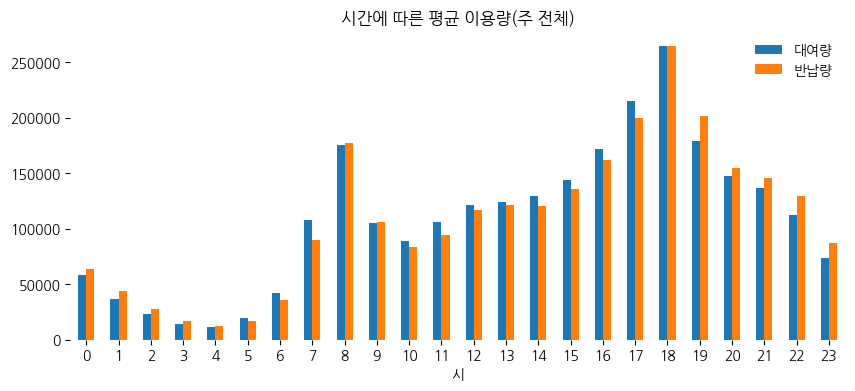

In [ ]:
# 시간대별 이용량 살펴보기
ax = pd.DataFrame(
    data={
        "대여량": df_2022.groupby('대여시간').size() // 7,
        "반납량": df_2022.groupby('반납시간').size() // 7
    }
).plot.bar(
    rot=0,
    xlabel="시",
    title="시간에 따른 평균 이용량(주 전체)",
    figsize=(10, 4)
)
ax.set_frame_on(False)
ax.legend(frameon=False);

평일의 경우, 대여/반납 시간대가 모두 8시와 18시에 몰려있다. 주로 출퇴근 시간에 몰린듯 하다.

주말의 경우, 밤시간대로 갈수록 몰린다. 주로 18시 전후로 최고치를 찍는다.

한편, 출근시간 제외하고, 일반적으로 낮에는 대여량 > 반납량이고, 밤에는 그 반대다.

## 지역별 대여 반납 비율 파악하기

In [9]:
### 거치소 dataframe
rental_df=pd.read_csv('/content/drive/MyDrive/ddareung/rental_spot.csv',low_memory=False,encoding='cp949')
del rental_df['LCD']
del rental_df['QR']
# rental_df_gu: 대여한 대여소번호의 자치구
rental_df_gu=rental_df[['대여소번호','자치구']]
rental_df_gu.columns=['대여대여소','대여지역']
# return_df_gu: 반납한 반납소번호의 자치구
return_df_gu=rental_df[['대여소번호','자치구']]
return_df_gu.columns=['반납대여소','반납지역']

In [ ]:
### 2022 dataframe과 대여소번호, 반납소번호를 key로 삼아 자치구만 추가해주기(대여지역, 반납 지역 다 있음)
df_2022=pd.merge(left = df_2022 , right = rental_df_gu, how = "inner", on = "대여대여소")
df_2022=pd.merge(left = df_2022 , right = return_df_gu, how = "inner", on = "반납대여소")
df_2022.isnull().sum()

In [44]:
df_2022.head()

대여일시  대여대여소     대여대여소이름  대여거치대                반납일시  반납대여소  \
0 2022-01-01 09:02:01    102  망원역 1번출구 앞      0 2022-01-01 09:18:25    102   
1 2022-01-01 14:12:25    102  망원역 1번출구 앞      0 2022-01-01 15:37:49    102   
2 2022-01-01 15:28:06    102  망원역 1번출구 앞      0 2022-01-01 15:43:32    102   
3 2022-01-01 18:33:00    102  망원역 1번출구 앞      0 2022-01-01 20:29:28    102   
4 2022-01-01 18:28:45    102  망원역 1번출구 앞      0 2022-01-01 20:29:48    102   

      반납대여소이름  반납거치대  이용시간      이용거리  ...        대여일자     반납연월  반납연도  반납월  \
0  망원역 1번출구 앞      0    16    693.23  ...  2022-01-01  2022-01  2022    1   
1  망원역 1번출구 앞      0    85      0.00  ...  2022-01-01  2022-01  2022    1   
2  망원역 1번출구 앞      0    15   1956.41  ...  2022-01-01  2022-01  2022    1   
3  망원역 1번출구 앞      0   116  16100.00  ...  2022-01-01  2022-01  2022    1   
4  망원역 1번출구 앞      0   121  17613.85  ...  2022-01-01  2022-01  2022    1   

   반납일  반납시간 반납요일        반납일자  대여지역  반납지역  
0    1     9    5  2022-01-01   마포구   마포구  
1    1    15    5  2022-01-01   마포구   마포구  
2    1    15    5  2022-01-01   마포구   마포구  
3    1    20    5  2022-01-01   마포구   마포구  
4    1    20    5  2022-01-01   마포구   마포구  

[5 rows x 26 columns]

In [11]:
#대여지역구와 반납지역구가 다른 경우(유입 유출 파악 위해)
df_2022[df_2022['대여지역']!=df_2022['반납지역']]

대여일시  대여대여소              대여대여소이름  대여거치대  \
5450     2022-01-04 14:47:47    115             마스타 빌딩 앞      0   
5451     2022-01-04 16:20:50    115             마스타 빌딩 앞      0   
5452     2022-01-05 15:46:57    115             마스타 빌딩 앞      0   
5453     2022-01-08 15:10:51    115             마스타 빌딩 앞      0   
5454     2022-01-15 08:49:41    115             마스타 빌딩 앞     99   
...                      ...    ...                  ...    ...   
18121362 2022-03-23 09:29:50   4884              H비즈니스파크      0   
18121374 2022-03-02 13:51:50   2377           수서역 5번출구 뒤      0   
18121375 2022-03-02 13:51:49   2377           수서역 5번출구 뒤      0   
18121376 2022-03-03 15:09:21   2377           수서역 5번출구 뒤      0   
18121377 2022-05-28 15:59:19   2425  세곡동 사거리(대왕초등학교 정류장)      0   

                        반납일시  반납대여소       반납대여소이름  반납거치대  이용시간     이용거리  ...  \
5450     2022-01-04 14:54:58    102    망원역 1번출구 앞      0     7      0.0  ...   
5451     2022-01-04 16:32:49    102    망원역 1번출구 앞      0    11   1770.0  ...   
5452     2022-01-05 15:59:29    102    망원역 1번출구 앞      0    12   1730.0  ...   
5453     2022-01-08 15:22:50    102    망원역 1번출구 앞      0    11   1760.0  ...   
5454     2022-01-15 08:57:51    102    망원역 1번출구 앞     99     8   1920.0  ...   
...                      ...    ...           ...    ...   ...      ...  ...   
18121362 2022-03-23 11:19:26   2532       국립국악원 앞      0   109  18710.0  ...   
18121374 2022-03-02 15:18:04   4314  탑성마을 버스정거장 옆      0    86   8210.0  ...   
18121375 2022-03-02 15:18:11   4314  탑성마을 버스정거장 옆      0    86   8250.0  ...   
18121376 2022-03-03 16:39:46   4314  탑성마을 버스정거장 옆      0    90   8250.0  ...   
18121377 2022-05-28 17:08:00   4314  탑성마을 버스정거장 옆      0    68   5080.0  ...   

                대여일자     반납연월  반납연도  반납월  반납일  반납시간 반납요일        반납일자  대여지역  \
5450      2022-01-04  2022-01  2022    1    4    14    1  2022-01-04  서대문구   
5451      2022-01-04  2022-01  2022    1    4    16    1  2022-01-04  서대문구   
5452      2022-01-05  2022-01  2022    1    5    15    2  2022-01-05  서대문구   
5453      2022-01-08  2022-01  2022    1    8    15    5  2022-01-08  서대문구   
5454      2022-01-15  2022-01  2022    1   15     8    5  2022-01-15  서대문구   
...              ...      ...   ...  ...  ...   ...  ...         ...   ...   
18121362  2022-03-23  2022-03  2022    3   23    11    2  2022-03-23   송파구   
18121374  2022-03-02  2022-03  2022    3    2    15    2  2022-03-02   강남구   
18121375  2022-03-02  2022-03  2022    3    2    15    2  2022-03-02   강남구   
18121376  2022-03-03  2022-03  2022    3    3    16    3  2022-03-03   강남구   
18121377  2022-05-28  2022-05  2022    5   28    17    5  2022-05-28   강남구   

          반납지역  
5450       마포구  
5451       마포구  
5452       마포구  
5453       마포구  
5454       마포구  
...        ...  
18121362   서초구  
18121374   서초구  
18121375   서초구  
18121376   서초구  
18121377   서초구  

[4830816 rows x 26 columns]

In [12]:
# 대여지역, 대여시간을 기준으로 대여량 확인
rental_by_time_region= df_2022[df_2022['대여요일'] < 5].groupby(['대여지역', '대여시간']).size() // 5
rental_by_time_region

대여지역  대여시간
강남구   0       1617
      1       1050
      2        723
      3        478
      4        329
              ... 
중랑구   19      5725
      20      4806
      21      4522
      22      3686
      23      2579
Length: 600, dtype: int64

In [13]:
# 대여시간대별이 column이 됨
rental_by_time_region_table = rental_by_time_region.unstack()
rental_by_time_region_table.head()

대여시간    0     1     2    3    4     5     6      7      8      9   ...     14  \
대여지역                                                               ...          
강남구   1617  1050   723  478  329   555  1347   3165   5438   3476  ...   3522   
강동구   2269  1319   848  529  462  1304  2885   6661   9025   4643  ...   4674   
강북구   1140   807   581  418  335   427   783   1559   2506   1599  ...   1749   
강서구   4136  2433  1473  909  950  2390  6749  19116  30931  13242  ...  11570   
관악구   2236  1366   976  650  539   810  1429   3520   5519   3063  ...   2908   

대여시간     15     16     17     18     19     20     21     22    23  
대여지역                                                                
강남구    4079   5404   8174  10629   5941   4332   3857   3111  1976  
강동구    5229   6820   8707  11220   8445   6795   6535   5156  3283  
강북구    2043   2428   2988   3946   2847   2469   2378   1948  1454  
강서구   13374  17135  24348  34357  21940  16700  15177  12028  7150  
관악구    3223   3877   5076   6967   5751   5073   4899   4340  3058  

[5 rows x 24 columns]

Text(114.234375, 0.5, '')

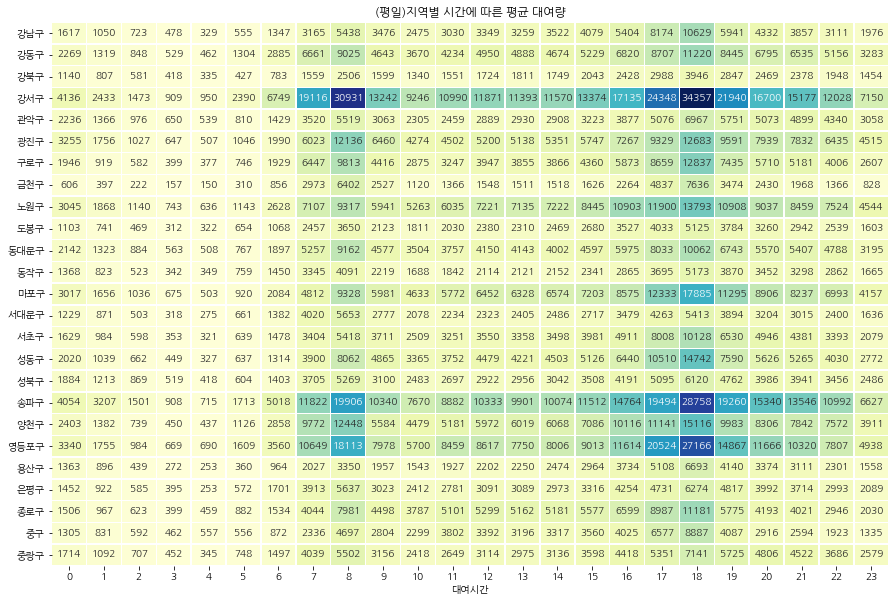

In [14]:
_, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(rental_by_time_region_table,
    annot=True,
    fmt='d',
    cmap="YlGnBu",
    cbar=False,
    linewidth=0.5,
    ax=ax
)
ax.set_title("(평일)지역별 시간에 따른 평균 대여량")
ax.set_ylabel("")

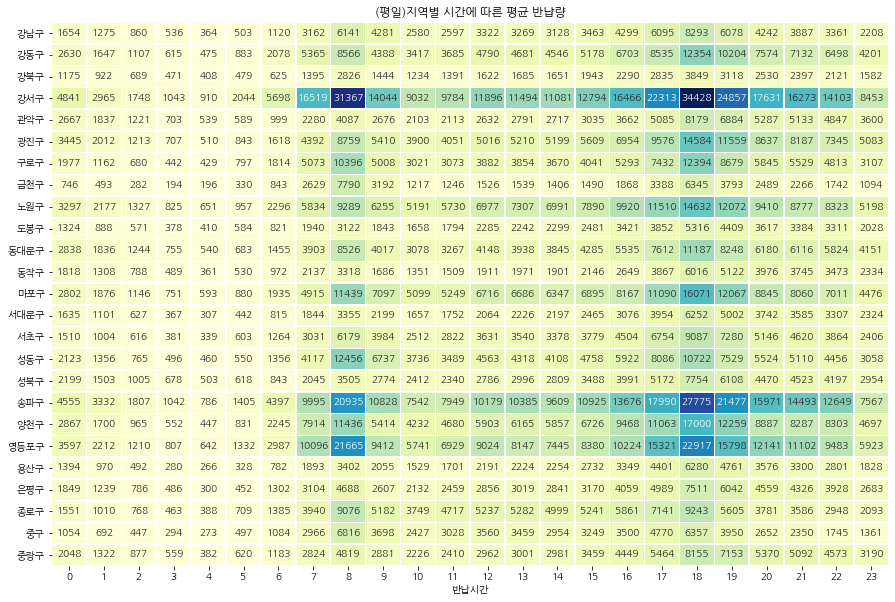

In [15]:
return_by_time_region=df_2022[df_2022['반납요일'] < 5].groupby(['반납지역', '반납시간']).size() // 5
return_by_time_region_table =return_by_time_region.unstack()

_, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(return_by_time_region_table,
    annot=True,
    fmt='d',
    cmap="YlGnBu",
    cbar=False,
    linewidth=0.5,
    ax=ax
)
ax.set_title("(평일)지역별 시간에 따른 평균 반냡량")
ax.set_ylabel("");

- 강서구, 송파구, 영등포구 공통적으로 대여, 반납 많음

- 출퇴근 시간에 공통적으로 색이 진하게 그려져 있음

- 그러면 출퇴근 시간에 대여량이 반납량보다 높은지역은?

- 반대로 반납량이 대여량보다 많은 지역은?

In [16]:
# 대여량 8시, 18시
rent_at_8and18 = pd.DataFrame(
    data=[rental_by_time_region.xs(8, level=1),rental_by_time_region.xs(18, level=1)], index=[8, 18]
)
rent_at_8and18

대여지역    강남구    강동구   강북구    강서구   관악구    광진구    구로구   금천구    노원구   도봉구  ...  \
8      5438   9025  2506  30931  5519  12136   9813  6402   9317  3650  ...   
18    10629  11220  3946  34357  6967  12683  12837  7636  13793  5125  ...   

대여지역    성동구   성북구    송파구    양천구   영등포구   용산구   은평구    종로구    중구   중랑구  
8      8062  5269  19906  12448  18113  3350  5637   7981  4697  5502  
18    14742  6120  28758  15116  27166  6693  6274  11181  8887  7141  

[2 rows x 25 columns]

In [17]:
# 반납량 8시, 18시
rtrn_at_8and18 = pd.DataFrame(
    data = [return_by_time_region.xs(8, level=1), return_by_time_region.xs(18, level=1)], index=[8, 18]
)
rtrn_at_8and18

반납지역   강남구    강동구   강북구    강서구   관악구    광진구    구로구   금천구    노원구   도봉구  ...  \
8     6141   8566  2826  31367  4087   8759  10396  7790   9289  3122  ...   
18    8293  12354  3849  34428  8179  14584  12394  6345  14632  5316  ...   

반납지역    성동구   성북구    송파구    양천구   영등포구   용산구   은평구   종로구    중구   중랑구  
8     12456  3505  20935  11436  21665  3402  4688  9076  6816  4819  
18    10722  7754  27775  17000  22917  6280  7511  9243  6357  8155  

[2 rows x 25 columns]

In [18]:
# 전체에서 대여 반납이 차지하는 비율 파악하기
total =rent_at_8and18 + rtrn_at_8and18
rent_at_8and18=rent_at_8and18 / total
rtrn_at_8and18=rtrn_at_8and18/total

In [19]:
# 출근시간 8시에서의 대여 반납량 차이
morning_diff = pd.DataFrame(
    data={'대여': rent_at_8and18.loc[8], '반납': rtrn_at_8and18.loc[8]}
).sort_values('대여')
# 퇴근시간 18시에서의 대여 반납량 차이
dinner_diff = pd.DataFrame(
    data={'대여': rent_at_8and18.loc[18], '반납': rtrn_at_8and18.loc[18]}
).sort_values('대여')

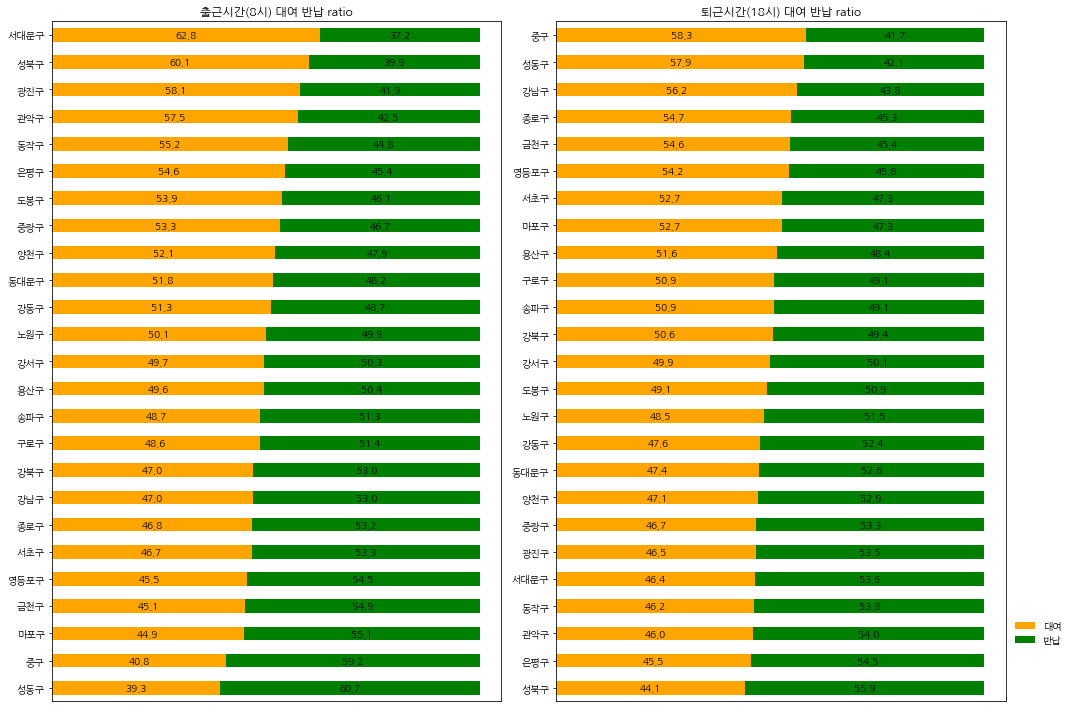

In [20]:
_, axes = plt.subplots(1, 2, figsize=(15, 10))

for i, (diff, time_name) in enumerate(zip([morning_diff, dinner_diff], ["출근시간(8시)", "퇴근시간(18시)"])):
    ax = diff.plot.barh(
        stacked=True,
        color=['orange', 'green'],
        title=f"{time_name} 대여 반납 ratio",
        ax=axes[i]
    )
    # patches는 막대기를 의미하는거
    for p in ax.patches: 
        x, y, width, height = p.get_bbox().bounds 
        ax.annotate("%.1f"%(width*100), (x+width/2, y+height/2), ha='center', va='center')
    ax.set_xticks([])

axes[0].get_legend().remove()
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.1), frameon=False)
_.tight_layout()

- 출근시간엔 서대문구가 대여가 25퍼 더 많음

- 중구, 성동구에서 아침에는 반납량이 많고 저녁에는 대여량이 많음


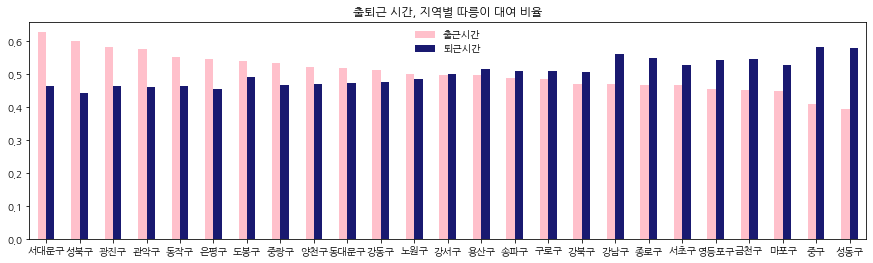

In [21]:
morning_dinner_diff = pd.DataFrame(
    data={'출근시간': morning_diff['대여'], '퇴근시간': dinner_diff['대여']}
).sort_values('출근시간', ascending=False)

ax = morning_dinner_diff.plot.bar(
    rot=0,
    color=['pink', 'midnightblue'],
    title="출퇴근 시간, 지역별 따릉이 대여 비율",
    figsize=(15, 4)
)
ax.legend(frameon=False);

- 출근시간 대여가 높은 지역(서대문구, 성북구,광진구 등)-> 거주지->근무지로 이동하는 것, 따라서 거주지역의 출근시간 대여량이 높음

- 퇴근시간 대여가 높은 지역(강남구, 종로구, 서초구, 영등포구, 금천구, 마포구, 중구, 성동구)-> 퇴근시간 대여량이 높음. 근무지->거주지로 이동

## 유출, 유입 많은 지역 살펴보기


In [22]:
# 지역 데이터 map 시각화를 위해 json데이터 불러오기
import json
from folium import plugins
lat=rental_df['위도'].mean()
long=rental_df['경도'].mean()

geo_path = '/content/drive/MyDrive/ddareung/seoul_geo.json'
with open(geo_path,encoding='utf-8') as fp:
    geo_str = json.load(fp)

### 자치구별 유출, 유입 비율 확인하기

In [23]:
# 유출비율-> 한 지역에서 대여 후 타 지역에서 반납한 량/한 지역에서의 대여량
out_from_region = df_2022[['대여지역', '반납지역']].groupby('대여지역').apply(
    lambda x: (x['대여지역'] != x['반납지역']).sum() / len(x) * 100
).sort_values(ascending=False)
# 유입비율-> 타 지역에서 대여 후 한 지역에 반납한 량/ 한 지역에서의 반납량
in_to_region = df_2022[['대여지역', '반납지역']].groupby('반납지역').apply(
    lambda x: (x['대여지역'] != x['반납지역']).sum() / len(x) * 100
).sort_values(ascending=False)


In [24]:
#유출이 많을수록, 유입이 많은걸까?
inoutflow= pd.DataFrame(
    data={'유출비율': out_from_region, '유입비율': in_to_region}
).sort_values(by='유출비율', ascending=False)
inoutflow.head()

유출비율       유입비율
중구    55.471180  52.976555
서대문구  50.316474  47.726057
동작구   47.023673  47.774885
성동구   43.111595  43.384966
성북구   42.732069  43.138240

In [25]:
inoutflow.corr()
# 유출비율과 유입비율은 거의 동일한 분포를 가진다. 즉 유출비율이 높은 지역은 유입비율도 높다. 상관계수 1에 수렴

유출비율     유입비율
유출비율  1.00000  0.99389
유입비율  0.99389  1.00000

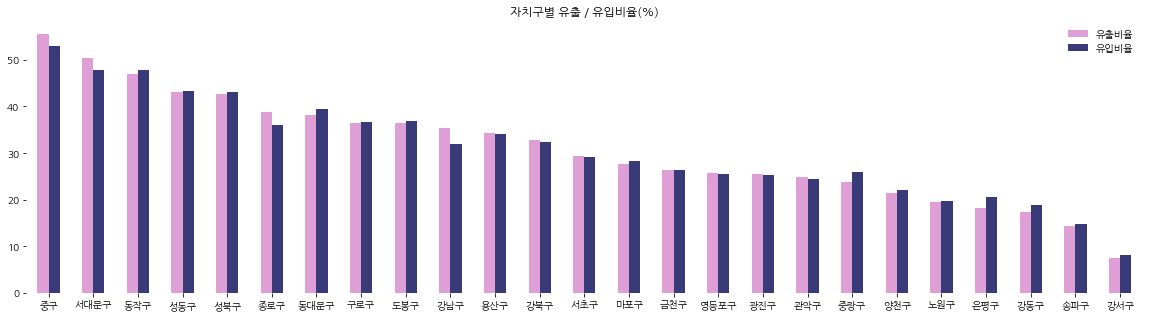

In [26]:
ax = inoutflow.plot(
    kind='bar',
    rot=0,
    colormap='tab20b_r',
    figsize=(20, 5)
)
ax.set_title("자치구별 유출 / 유입비율(%)")
ax.legend(frameon=False)
ax.set_frame_on(False)

In [29]:
# 왼쪽은 유출 비율 오른쪽은 유입 비율
inoutflow_by_district_map = folium.plugins.DualMap(
    location=[lat,long],
    zoom_start=10.8,
    tiles='CartoDB positron',
    zoom_control=False
)
folium.Choropleth(geo_str,
    data=out_from_region,
    key_on='feature.properties.SIG_KOR_NM', 
    fill_color='PuRd',
    line_color='grey',
    highlight=True
).add_to(inoutflow_by_district_map.m1)

folium.Choropleth(geo_str,
    data=in_to_region,
    key_on='feature.properties.SIG_KOR_NM', 
    fill_color='Purples',
    line_color='grey',
    highlight=True
).add_to(inoutflow_by_district_map.m2)

inoutflow_by_district_map.save('/content/drive/MyDrive/ddareung/inoutflow_by_district_map.html')

In [30]:
inoutflow_by_district_map

### 시간대에 따른 자치구별 유출 유입 비율 확인하기

- 단순한 자치구별 유출 유입 비율이 아닌 시간대에 따른 비율을 확인하여보자

In [31]:
# 주중 데이터로 파악하자
df_weekday = df_2022[df_2022['대여요일'] < 5]
# 주중 유출
out_from_region_weekday = df_weekday.groupby('대여지역').apply(
    lambda x: x[x['대여지역'] != x['반납지역']].groupby('대여시간').size() \
               / x.groupby('대여시간').size() * 100
)
out_from_region_weekday.head()

대여시간         0          1          2          3          4          5   \
대여지역                                                                     
강남구   38.820183  35.617742  36.780973  37.886383  33.474833  34.870317   
강동구   18.285160  17.171870  16.148043  17.742544  25.021608  24.172287   
강북구   39.400316  36.363636  37.035763  39.837398  44.338498  33.193081   
강서구   10.671115  11.875411  13.804805  16.728951  14.934792   7.044846   
관악구   21.017798  20.119988  19.971323  23.977867  32.209044  34.739699   

대여시간         6          7          8          9   ...         14         15  \
대여지역                                              ...                         
강남구   25.244880  29.656305  29.863205  21.559264  ...  30.288407  33.462425   
강동구   24.714038  18.711905  20.031025  16.810957  ...  15.579137  15.924736   
강북구   36.820618  35.561257  29.952115  33.900213  ...  30.288132  29.399100   
강서구    8.198761   7.541248   4.893473   5.583496  ...   7.082109   6.841428   
관악구   31.621659  39.798875  43.627931  28.164784  ...  23.947730  23.531236   

대여시간         16         17         18         19         20         21  \
대여지역                                                                     
강남구   36.883790  43.132218  48.174839  41.437468  38.563449  35.993156   
강동구   15.524927  17.366837  16.816983  14.792185  16.260043  17.249610   
강북구   33.042332  32.394083  36.993868  31.846597  31.038951  32.352199   
강서구    7.332361   8.421226   8.975702   6.788390   6.797605   6.960441   
관악구   23.162239  24.065246  24.680656  20.532703  21.601167  20.772276   

대여시간         22         23  
대여지역                        
강남구   37.547400  36.356275  
강동구   13.812498  13.364196  
강북구   34.969199  36.463633  
강서구    7.151646   8.052246  
관악구   20.720638  20.589774  

[5 rows x 24 columns]

In [32]:
# 주중 유입

in_to_region_weekday = df_weekday.groupby('반납지역').apply(
    lambda df: df[df['대여지역'] != df['반납지역']].groupby('반납시간').size() \
               / df.groupby('반납시간').size() * 100
)
in_to_region_weekday.head()

반납시간         0          1          2          3          4          5   \
반납지역                                                                     
강남구   33.298023  39.455677  38.618452  37.010809  35.164835  39.515488   
강동구   20.175439  24.029419  25.460455  23.636364  21.825063  13.994565   
강북구   36.272879  38.008658  39.037123  43.832132  48.287671  45.093946   
강서구   12.381374  17.322570  16.708543  16.835855  13.463650   7.494374   
관악구   26.009231  30.640970  24.599280  23.699915  24.990744  18.656716   

반납시간         6          7          8          9   ...         14         15  \
반납지역                                              ...                         
강남구   27.258122  37.084124  40.310027  35.841741  ...  26.954798  26.355604   
강동구    6.544125  10.925967  12.882891  13.699130  ...  15.128453  18.945539   
강북구   35.956494  32.239576  39.016277  30.762841  ...  27.277132  28.550844   
강서구    3.559144   4.489376   5.388363   6.023839  ...   6.098397   6.529215   
관악구   14.588753  18.135578  22.482630  21.575368  ...  21.570503  23.018644   

반납시간         16         17         18         19         20         21  \
반납지역                                                                     
강남구   26.390956  28.684867  32.166112  35.840737  33.900622  32.391830   
강동구   19.484471  20.794770  25.643475  25.040179  21.784479  21.301593   
강북구   30.670508  33.142857  34.994026  36.882617  30.387352  29.318542   
강서구    6.983749   6.942141  10.395548  12.008303   9.569183   9.210348   
관악구   23.618392  29.072603  38.552007  32.467608  24.442091  22.502727   

반납시간         22         23  
반납지역                        
강남구   31.762746  31.356393  
강동구   20.808199  23.629094  
강북구   33.622478  32.250727  
강서구    9.912222  11.604249  
관악구   21.444192  22.019776  

[5 rows x 24 columns]

- 유입 비율에서 유출 비율을 뺀 값을 지표로 삼아 cluster map

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.


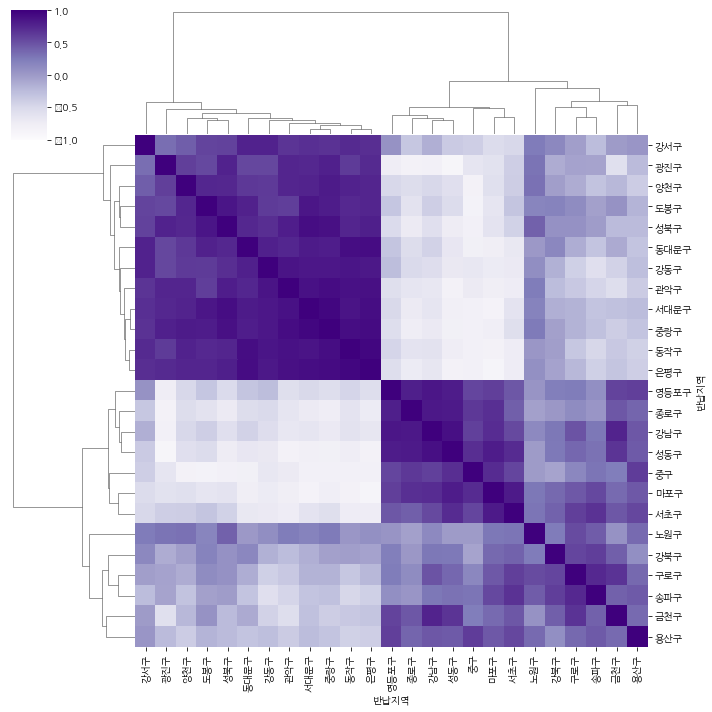

In [33]:
inout_ratio = in_to_region_weekday - out_from_region_weekday
clustergrid = sns.clustermap(inout_ratio.T.corr(),
    cmap='Purples',
    vmin=-1,
    vmax=1,
    cbar=True
)

In [34]:
reordered_ind = clustergrid.dendrogram_row.reordered_ind
inout_ratio.index[reordered_ind]

Index(['강서구', '광진구', '양천구', '도봉구', '성북구', '동대문구', '강동구', '관악구', '서대문구', '중랑구',
       '동작구', '은평구', '영등포구', '종로구', '강남구', '성동구', '중구', '마포구', '서초구', '노원구',
       '강북구', '구로구', '송파구', '금천구', '용산구'],
      dtype='object', name='반납지역')

In [35]:
inout_ratio = inout_ratio.reindex(inout_ratio.index[reordered_ind])
inout_ratio.head()

반납시간        0         1         2         3          4         5          6   \
반납지역                                                                           
강서구   1.710259  5.447159  2.903738  0.106904  -1.471141  0.449528  -4.639618   
광진구  -5.696194 -1.349770 -2.268374 -3.621495  -3.142261 -0.522595  -5.910524   
양천구   3.332829  4.166751  4.339189  5.417053  12.970935 -8.951974  -5.299759   
도봉구   4.569103  1.602919  1.610026  8.680575  12.437268  1.661977  -8.798267   
성북구   2.648646  4.110431  1.391269  7.894891   7.490984  3.784123 -18.708721   

반납시간         7          8          9   ...        14        15        16  \
반납지역                                   ...                                 
강서구   -3.051872   0.494890   0.440343  ... -0.983712 -0.312213 -0.348612   
광진구  -15.534666 -22.234655 -14.899995  ...  1.862815  1.172031  0.891332   
양천구   -9.611892  -6.938359  -3.391772  ...  0.822684  0.188957 -1.023746   
도봉구  -11.897277  -7.497114  -4.272111  ... -1.778570 -0.974833  0.801282   
성북구  -28.085986 -19.342637  -4.681309  ... -1.829588  2.510357  0.538330   

반납시간        17         18         19        20        21        22        23  
반납지역                                                                          
강서구  -1.479084   1.419846   5.219913  2.771578  2.249908  2.760576  3.552003  
광진구   5.507734  11.902917  10.137792  4.611047  1.707747  0.103607 -0.832476  
양천구   1.985421   8.979264  11.065789  3.069835  1.910076 -2.111554  0.943707  
도봉구  -0.712953   1.576711   8.819341  7.224374  5.896547  6.587012  3.162536  
성북구   2.989609  11.865749  11.139934  7.528674  6.208514  4.390322  2.724318  

[5 rows x 24 columns]

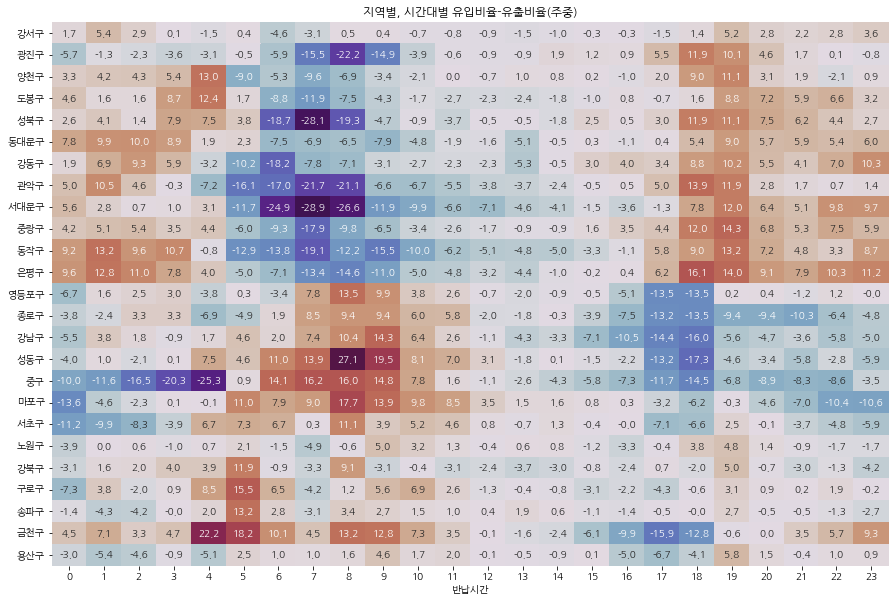

In [36]:
# 시간에 따른 각 지역별 (유입 - 유출비율) 히트맵
_, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(inout_ratio,
    vmin=-32,
    vmax=32,
    square=False,
    annot=True,
    fmt=".1f",
    cmap='twilight_shifted', 
    cbar=False,
    ax=ax
)
ax.set_title("지역별, 시간대별 유입비율-유출비율(주중)")
ax.set_ylabel("");

- Cluster A: 강서구~은평구-> 출근하는 사람들이 많은 주거지역

- Cluster B: 영등포구~용산구-> 출근시간에 유입이 많은 경제활동지역

### 유입/유출이 가장 활발한 지역은?
- 출근 시간대에 유입이 아주 높고 퇴근 시간에 유출이 심한 경우
- 위의 반대인 경우

In [37]:
inout_diff = (abs(inout_ratio.iloc[:, 7:10].mean(axis=1)) + abs(inout_ratio.iloc[:, 17:20].mean(axis=1))).sort_values(ascending=False)
inout_diff

반납지역
성동구     31.873904
서대문구    28.617496
광진구     26.739253
관악구     26.737209
중구      26.607377
성북구     26.035075
은평구     25.066658
동작구     24.933917
강남구     22.736643
중랑구     21.654481
종로구     21.148557
금천구     19.928505
영등포구    19.323075
마포구     16.820319
양천구     13.990832
강동구     13.516106
동대문구    12.046841
도봉구     11.116534
서초구      8.801712
용산구      4.070899
노원구      2.901523
강서구      2.425771
강북구      2.130020
송파구      1.703907
구로구      1.469122
dtype: float64

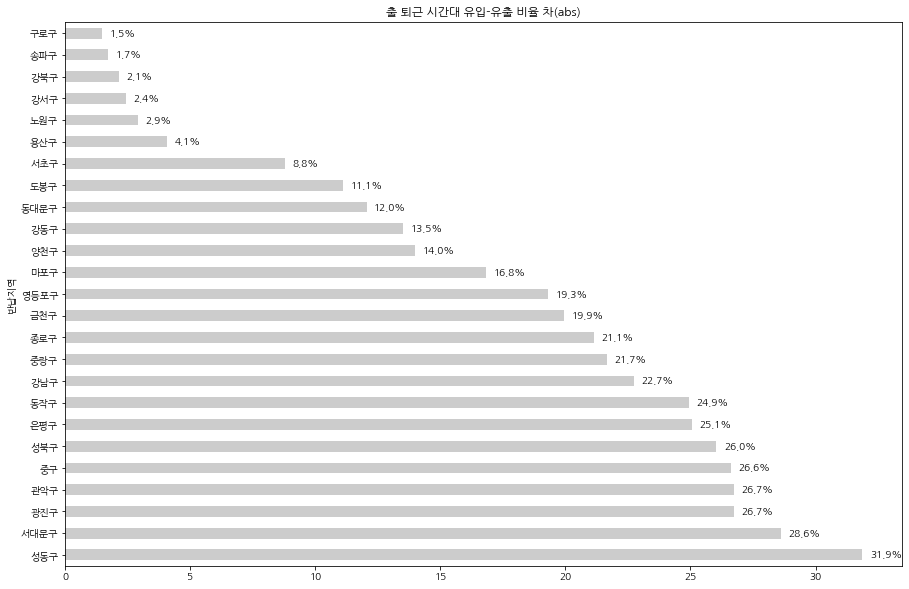

In [38]:
# 차이값이 큰 순으로 정렬
ax = inout_diff.plot(
    kind='barh',
    rot=0,
    colormap='nipy_spectral_r',
    title="출 퇴근 시간대 유입-유출 비율 차(abs)",
    figsize=(15, 10)
)
for p in ax.patches: 
    x, y, width, height = p.get_bbox().bounds
    ax.text(width+0.3, y+height/2, f"{width:.1f}%", va='center')

In [39]:
# 색이 진할수록 값이 크다.
inout_diff_map  = folium.Map(
    location=[lat,long],
    zoom_start=10,
    tiles='CartoDB positron',
    zoom_control=False
)
folium.Choropleth(geo_str,
    data=inout_diff,
    key_on='feature.properties.SIG_KOR_NM', 
    fill_color='YlGnBu',
    line_color='grey',
    highlight=True
).add_to(inout_diff_map)

inout_diff_map.save("/content/drive/MyDrive/ddareung/inout_diff_map.html")
inout_diff_map

- 성동구, 서대문구 등이 출 퇴근 시간의 유입, 유출 간의 차이가 큼
- 성동구는 특히 출근 시간의 유입이 많아 자전거 거치소에 많은 자전거가 있을 것이라 추정됨

## 성동구 거치소 시간대별 파악 및 재분배
- 아침 시간 대에 성동구의 따릉이 반납량이 많으므로 평균적으로 적은 따릉이가 배치되는 거치소를 찾아 이곳에 거치하도록 유도하기  

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.


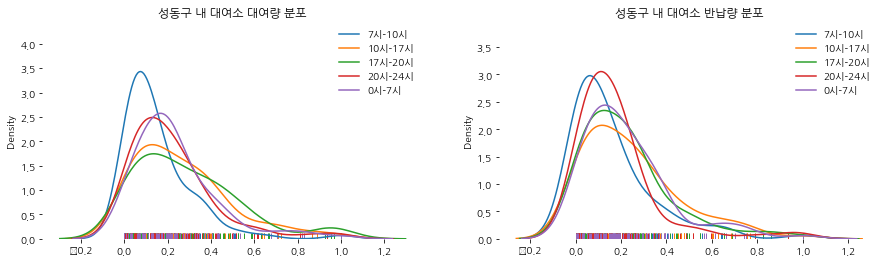

In [171]:
# 평일 지역구 대여소별 대여량 및 반납량 분포

df_weekdays = df_2022[df_2022['대여요일'].isin(range(0, 5))]

time_range = [range(7, 10), range(10, 17), range(17, 20), range(20, 24), range(0, 7)]
_, axes = plt.subplots(ncols=2, figsize=(15, 4))

def normalized_df(region):
  for ax, use in zip(axes, ['대여', '반납']):
    for i, time in enumerate(time_range):
      #시간별로
        use_by_region_time = df_weekdays[
            (df_weekdays[f'{use}지역'] == region) & (df_weekdays[f'{use}시간'].isin(time))
        ]
        #대여소에 따른 시간별 대여/반납 대여소 대여/반납량
        use_by_region_time= use_by_region_time.groupby(f'{use}대여소').size()
        # print(use_by_region_time)
        #정규화
        use_by_region_time = stats.zscore(use_by_region_time)
        use_by_region_time = (use_by_region_time - use_by_region_time.min()) / (use_by_region_time.max() - use_by_region_time.min())
        
        sns.kdeplot(use_by_region_time, label=f"{time[0]}시-{time[-1]+1}시", color=f"C{i}", ax=ax)
        sns.rugplot(use_by_region_time, ax=ax)
        
    ax.set_frame_on(False)
    ax.set_title(f"{region} 내 대여소 {use}량 분포")
    ax.legend(frameon=False)


normalized_df('성동구')

- 위를 통해 대여소의 이용량이 어떻게 변화하는지 살펴볼 수 있다.
- 출근시간대(7시~10시)를 살펴보면 left skewed상태이므로 이용량이 몇몇 대여소에 쏠려 있는 것을 확인할 수 있다.
- 시간이 지날수록 skewed 상태가 해소된다.

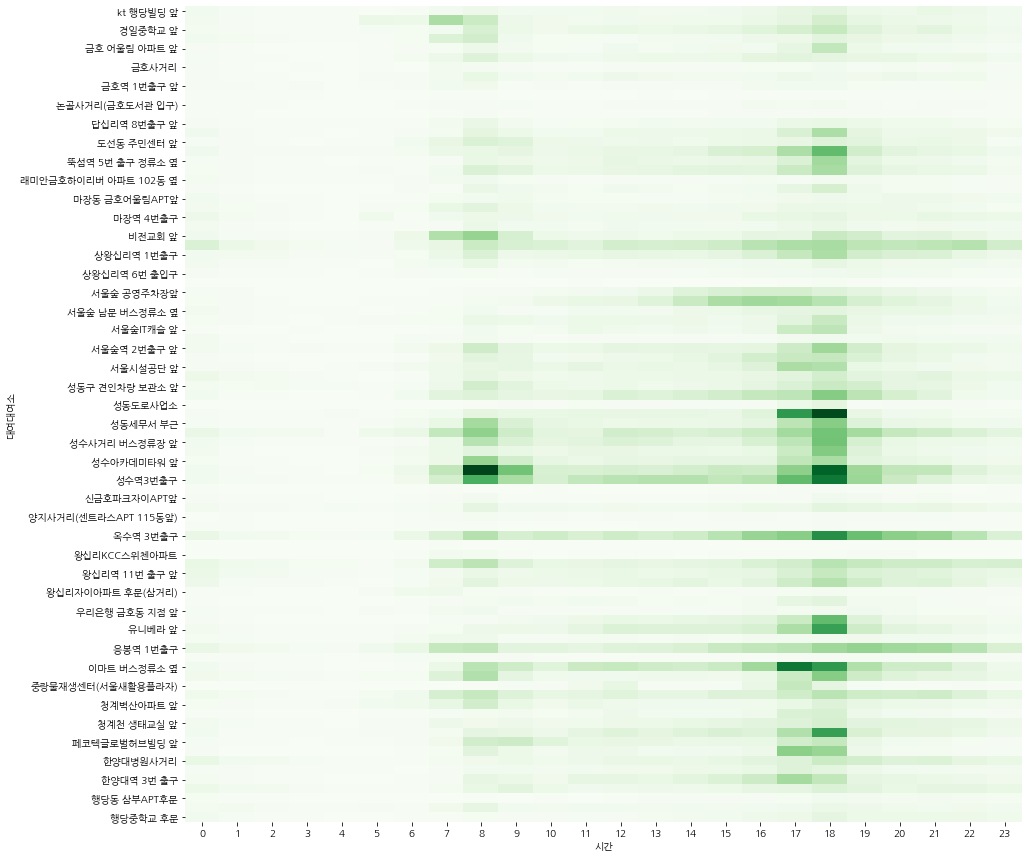

In [174]:
rental_by_region_time=df_weekdays[df_weekdays['대여지역'] == '성동구'].pivot_table(
        index='대여대여소이름', columns='대여시간', aggfunc='size', fill_value=0)

_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(rental_by_region_time, cmap='Greens', cbar=False, ax=ax)
ax.set_xlabel("시간")
ax.set_ylabel("대여대여소")

- 위의 정규분포와 같이 퇴근시간대에 비해 출근시간대에는 대여대여소의 사용이 특정 대여소에 제한되어 있다.

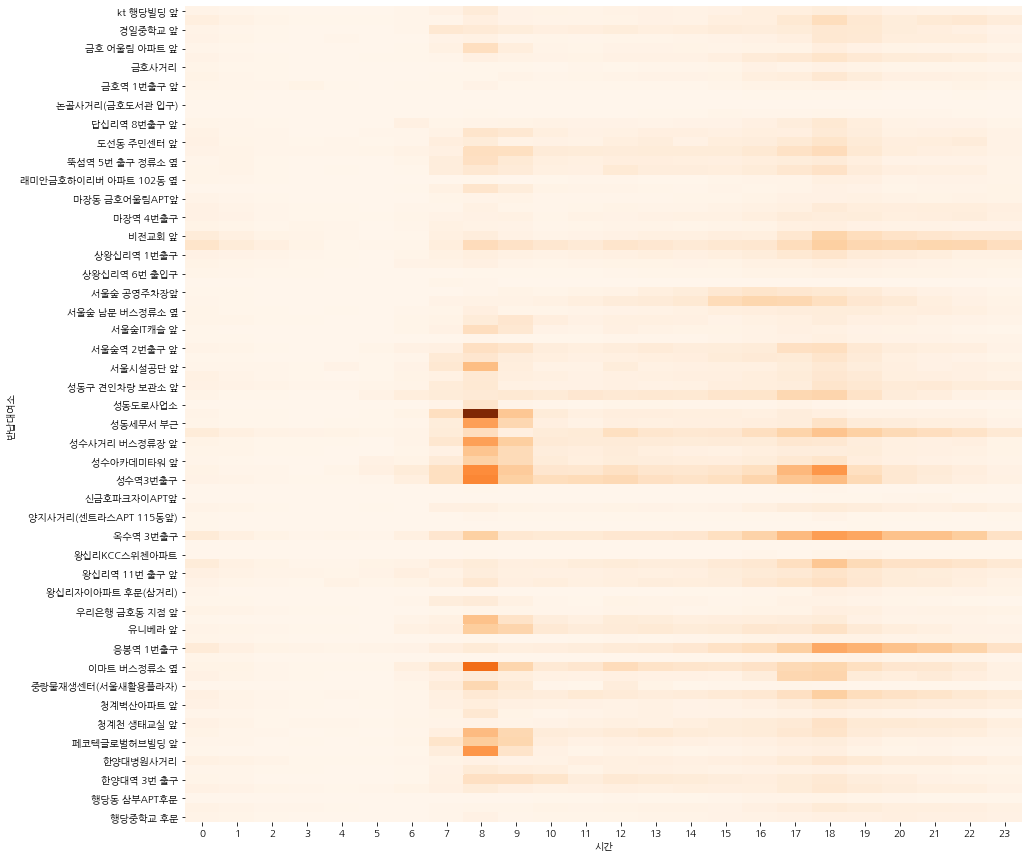

In [175]:
return_by_region_time=df_weekdays[df_weekdays['반납지역'] == '성동구'].pivot_table(
        index='반납대여소이름', columns='반납시간', aggfunc='size', fill_value=0
    )
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(return_by_region_time, cmap='Oranges', cbar=False, ax=ax)
ax.set_xlabel("시간")
ax.set_ylabel("반납대여소")

- 경제 활동지역이라 출근시간대에 반납이 활발하지만 다소 특정 반납소에 몰려 있다.

In [176]:
from folium.plugins import MarkerCluster

myMap = folium.Map([lat, long], zoom_start = 10)
coords = []
for i in range(len(rental_df)-1):
    x = rental_df['위도'][i]
    y = rental_df['경도'][i]
    coords.append([x, y])
    
for i in range(len(coords)):
    folium.Circle(
        location = coords[i],
        radius = 100,
        color = 'RdYlGn',
        fill = 'crimson',
    ).add_to(myMap)
    
# folium.Marker([37.527157, 126.9319],
#   popup="여의나루역 1번출구 앞",
#   icon=folium.Icon(color='green', icon='fa-bicycle',prefix='fa')).add_to(myMap)

# folium.CircleMarker([37.527157, 126.9319],
#   radius=100,
#   color='blue',
#   fill_color='skyblue').add_to(myMap)

def plot(df):
    # 리스트를 이용해 여러 행의 데이터를 위,경도로 묶음
    locations = list(zip(df.위도, df.경도))
    # 반복문을 이용해 locations로 정의한 변수에 해당하는 위치에 자동차 모양의 빨간색 아이콘을 지정했다.
    icons = [folium.Icon(icon='fa-bicycle', prefix="fa", color="blue") for _ in range(len(locations))]

    # 역시 같은 원리로 아이콘을 클릭했을 때, 팝업이 생성되게 할 예정인데, 먼저 팝업 안에 들어갈 내용을 지정한다.
    popup_content = []
    for information in df.itertuples():
        content = "<b>대여소번호 : {}</b>  <br /> 대여소명: {}".format(information.대여소번호, information._2)
        popup_content.append(content)
    popups = [folium.Popup(content, min_width=300, max_width=300) for content in popup_content]
    cluster = MarkerCluster(locations = locations, icons = icons, popups = popups)
    # 지도에 클러스터를 추가.
    cluster.add_to(myMap)
    
plot(seongdong_df)
myMap.save('/content/drive/MyDrive/ddareung/seongdong_df.html')
myMap

- **구현하길 원하는 것** -> 도착지를 입력하면 위도 경도 데이터를 바탕으로 인근 지역의 아침에 대여할 때는 대여량이 적은 곳 추천, 반납할 때는 반납량이 적은 곳 추천. 퇴근 시간대에는 딱히 문제가 없어보임

- 성동구와 반대의 조건인 서대문구도 한 번 시현해보면 좋아보임

- folium을 통해 위의 사항을 지도 위에 나타내면 좋을 것 같음

## 2018년 데이터 전처리 및 2018-2022 데이터(무시해도됨)

In [ ]:
# bike_path='data/'
# bike_list=os.listdir(bike_path)
# df=[]
# for file in bike_list:
#     file_path=os.path.join(bike_path,file)
#     file_name='bike_'+file_path.split('.')[0][-4:]
#     file_name=pd.read_csv(file_path,low_memory=False)
#     df.append(file_name)

# weather_path='weather/'
# weather_list=os.listdir(weather_path)
# weather_df=[]
# for file in weather_list:
#     file_path=os.path.join(weather_path,file)
#     file_name='weather_'+file_path.split('.')[0][-4:]
#     file_name=pd.read_excel(file_path)
#     weather_df.append(file_name)
# print(df[4]['대여대여소이름'].dtypes)
# df[4]['대여대여소이름']=df[4]['대여대여소이름'].astype('object')
# df[4]['대여대여소이름']=df[4]['대여대여소이름'].str.replace("'","")
# #2018
# df[4].head()
# df[4]['대여대여소이름']=df[4]['대여대여소이름'].str.strip()

In [ ]:
# df_return_group = df_2022.groupby(["반납대여소이름","반납대여소"])["반납일시"].count()
# df_return = pd.DataFrame(df_return_group).reset_index()
# df_return.columns = ["반납대여소이름","반납대여소", "반납수"]
# df_return
# 대여량이 많은 상위 대여소 
# for i in range(5):
#     print('반납량 많은 상위 대여소 top 10\n',df[i]['반납대여소이름'].value_counts().head(5))
# print('반납량 많은 상위 대여소 top 10\n',df_return.sort_values('반납수',ascending=False))

In [ ]:
# # 오전엔 반납거치소가 성동구인쪽을 기준으로 거치소별 데이터?
# def get_arrows(locations, color='blue', weight=1, size=6, n_arrows=3, some_map=None):
    
#     '''
#     Get a list of correctly placed and rotated 
#     arrows/markers to be plotted
    
#     Parameters
#     locations : list of lists of lat lons that represent the 
#                 start and end of the line. 
#                 eg [[41.1132, -96.1993],[41.3810, -95.8021]]
#     arrow_color : default is 'blue'
#     size : default is 6
#     n_arrows : number of arrows to create.  default is 3
#     Return
#     list of arrows/markers
#     '''

#     Point = namedtuple('Point', field_names=['lat', 'lon'])
    
#     # creating point from our Point named tuple
#     p1 = Point(locations[0][0], locations[0][1])
#     p2 = Point(locations[1][0], locations[1][1])
    
#     # getting the rotation needed for our marker.  
#     # Subtracting 90 to account for the marker's orientation
#     # of due East(get_bearing returns North)
#     rotation = get_bearing(p1, p2) - 90
    
#     # get an evenly space list of lats and lons for our arrows
#     # note that I'm discarding the first and last for aesthetics
#     # as I'm using markers to denote the start and end
#     arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
#     arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
#     arrows = []
    
#     #creating each "arrow" and appending them to our arrows list
#     for points in zip(arrow_lats, arrow_lons):
#         arrows.append(folium.RegularPolygonMarker(location=points, 
#                       fill_color=color, number_of_sides=3, opacity=weight,
#                       radius=size, rotation=rotation).add_to(some_map))
#     return arrows

# def get_bearing(p1, p2):
    
#     '''
#     Returns compass bearing from p1 to p2
    
#     Parameters
#     p1 : namedtuple with lat lon
#     p2 : namedtuple with lat lon
    
#     Return
#     compass bearing of type float
    
#     Notes
#     Based on https://gist.github.com/jeromer/2005586
#     '''
    
#     long_diff = np.radians(p2.lon - p1.lon)
    
#     lat1 = np.radians(p1.lat)
#     lat2 = np.radians(p2.lat)
    
#     x = np.sin(long_diff) * np.cos(lat2)
#     y = (np.cos(lat1) * np.sin(lat2) 
#         - (np.sin(lat1) * np.cos(lat2) 
#         * np.cos(long_diff)))
#     bearing = np.degrees(np.arctan2(x, y))
    
#     # adjusting for compass bearing
#     if bearing < 0:
#         return bearing + 360
#     return bearing
# def draw_traffic(df, dayofweek, time, region, marker_on=False, heatmap=False, arrow=True):
#     if dayofweek == "평일":
#         _dayofweek = range(0, 5)
#     elif dayofweek == "주말":
#         _dayofweek = range(5, 7)
#     else:
#         raise "dayofweek 인자를 평일 또는 주말로 입력해주세요."

#     # 대여지역 또는 반납지역이 region인 데이터만 모은다.
#     df = df[(df['대여지역'] == region) | (df['반납지역'] == region)]
#     # 평일 또는 주말별로 데이터를 모은다.
#     df = df[(df['대여요일'].isin(_dayofweek)) & (df['대여시간'].isin(time))]

#     # 트래픽 라인 그리기
#     by_rental = (df.groupby(['대여대여소', '반납대여소']).size()
#         .rename('weight')
#         .to_frame()
#         .merge(rental_df[['위도', '경도']], left_on='대여대여소', right_index=True)
#         .rename(columns={'위도': '대여대여소위도', '경도': '대여대여소경도'})
#         .merge(rental_df[['위도', '경도']], left_on='반납대여소', right_index=True)
#         .rename(columns={'위도': '반납대여소위도', '경도': '반납대여소경도'})
#     )
#     by_rental['weight'] /= by_rental['weight'].max() # normalize
#     # - 지도 먼저 그려주기.
#     center = by_rental[['대여대여소위도', '대여대여소경도']].mean(axis=0)
#     bike_map = folium.Map(
#         location=center,
#         zoom_start=10,
#         zoom_control=False
#     )

#     folium.TileLayer(
#         tiles='CartoDB positron',
#         overlay=True
#     ).add_to(bike_map)

#     for _, ds in by_rental.iterrows():
#         # [weight, 대여대여소위도, 대여대여소경도, 반납대여소위도, 반납대여소경도]
#         # print(ds)
#         _row = ds.to_numpy()
#         weight = _row[0]
#         # 화살표 추가
#         if arrow and weight >= 0.15:
#             # 화살표 다 그리면 렌더링이 힘드니, 0.3 이상만 그려준다.
#             arrows = get_arrows(
#                 [_row[1:3], _row[3:5]], weight=weight, size=2, n_arrows=3, some_map=bike_map
#             )
#             for arrow in arrows:
#                 arrow.add_to(bike_map)

#         line = _row[1:].reshape((2, 2)) # [(_row[2], _row[2]), (_row[3], _row[4])]
#         folium.PolyLine(line, opacity=weight+0.05, weight=0.5).add_to(bike_map)

#     # 지역 폴리곤 추가.
#     for region_data in geo_str['features']:
#         if region_data['properties']['SIG_KOR_NM'] == region:
#             polygon = np.array(region_data['geometry']['coordinates'])[0][:, (1, 0)] # 위도 경도 위치 바꾸는 거
#             folium.Polygon(polygon, color='Greens').add_to(bike_map)
#             break
#     return bike_map
# draw_traffic(df_2022, "주말", range(7,10), "동대문구", marker_on=True)
# # draw_traffic(df_2022, "평일", range(17,20), "성동구", marker_on=True)